In [1]:
import pandas as pd

df = pd.read_csv('Musical_instruments_reviews.csv')
df['text'] = df['summary'] + ". " + df['reviewText']
def classify_point(point):
    if point >= 4:
        return 'Positive'
    elif point == 3:
        return 'Neutral'
    else:
        return 'Negative'
df['overall'] = df['overall'].apply(classify_point)
df = df.dropna(subset=['text'])
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",Positive,good,1393545600,"02 28, 2014","good. Not much to write about here, but it doe..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,Positive,Jake,1363392000,"03 16, 2013",Jake. The product does exactly as it should an...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,Positive,It Does The Job Well,1377648000,"08 28, 2013",It Does The Job Well. The primary job of this ...


In [2]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('stopwords')

[nltk_data] Error loading omw-1.4: <urlopen error [Errno 2] No such
[nltk_data]     file or directory>
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.replace(".", ". ").replace("!", ". ")
    text = re.sub(r'[^a-zA-z\s]','',text)
    text = [word.lower() for word in text.split() if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

df['cln_text'] = df['text'].apply(preprocess_text)
df = df[df['cln_text'].str.len() > 0]
df[['reviewText', 'cln_text', 'summary']].head(3)

,reviewText,cln_text,summary
0,"Not much to write about here, but it does exac...",good not much write exactly supposed filter po...,good
1,The product does exactly as it should and is q...,jake the product exactly quite affordable i re...,Jake
2,The primary job of this device is to block the...,it doe the job well the primary job device blo...,It Does The Job Well


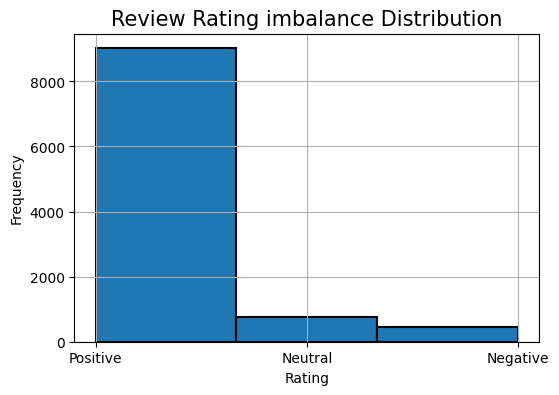

In [4]:
import matplotlib.pyplot as plt

df['overall'].hist(
    bins=3,
    grid=True,
    figsize=(6, 4),
    edgecolor='black',
    linewidth=1.5,
)

plt.title("Review Rating imbalance Distribution", fontsize=15)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [6]:
def plot_history(history):
    plt.figure(figsize=(10, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [9]:
%%time
import numpy as np

# prepare sequence data
NUM_WORDS = 30_000
MAX_SEQUENCE_LENGTH = 32
OOV_TOKEN = '<OOV>'
PADDING = 'post'

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ', oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df["cln_text"])
X = tokenizer.texts_to_sequences(df["cln_text"])
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH, padding=PADDING, truncating=PADDING)

Y = pd.get_dummies(df['overall']).values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=df["overall"], test_size = 0.1, random_state = 43, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y.argmax(axis=1)), y = Y.argmax(axis=1))
class_weights = dict(zip(np.unique(Y.argmax(axis=1)), class_weights)) 
print("class_weights: ", class_weights)

vocab_size = len(tokenizer.word_index) + 1

(9228, 32) (9228, 3)
(1026, 32) (1026, 3)
class_weights:  {0: 7.319057815845825, 1: 4.427461139896373, 2: 0.3791458679977815}
CPU times: total: 609 ms
Wall time: 617 ms


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 32)            666464    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 32, 32)            0         
 alDropout1D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


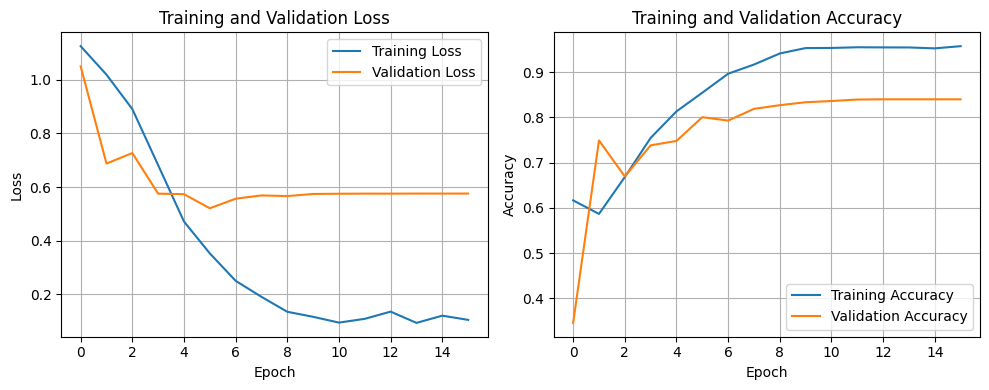

CPU times: total: 17min 51s
Wall time: 1min 53s


In [12]:
%%time

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Sequential 序列模型

def build_model(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
    model.add(SpatialDropout1D(0.5))
    model.add(Flatten())
#     model.add(GlobalAveragePooling1D())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

batch_size = 16
model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)
history = model.fit(X_train, Y_train, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, y_pred.round()))
print('F1 score:', f1_score(Y_test, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round())) 

plot_history(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 32)            666464    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 32, 32)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 512)               16896     
                                                      

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


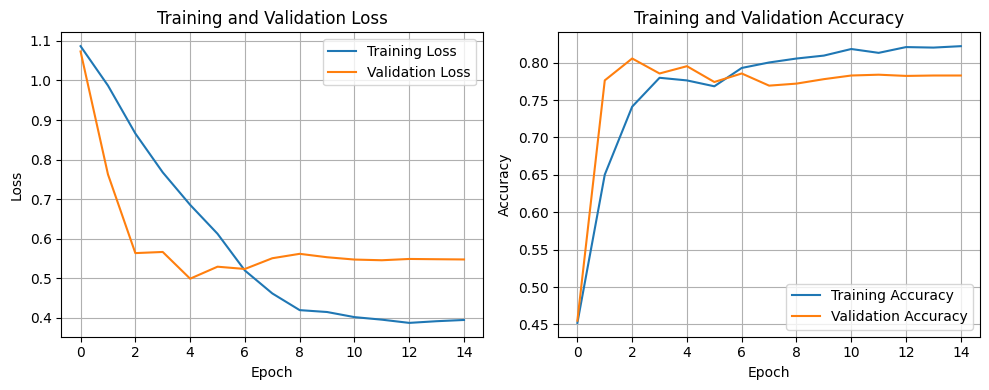

CPU times: total: 6min
Wall time: 1min 4s


In [13]:
%%time
# 增加双向LSTM层，并使用SpatialDropout1D层来减少过拟合
def build_model(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
    model.add(SpatialDropout1D(0.5))
    model.add(Bidirectional(LSTM(32, recurrent_dropout=0.0, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(16, recurrent_dropout=0.0, dropout=0.5)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(Y_train.shape[1],activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

batch_size = 64

model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)

history = model.fit(X_train, Y_train, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, y_pred.round()))
print('F1 score:', f1_score(Y_test, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round())) 

plot_history(history)

由上述结果得，使用三分类的分类效果欠佳，考虑简化问题，将评分分类为二分类

In [14]:
df = pd.read_csv('Musical_instruments_reviews.csv')
df['text'] = df['summary'] + ". " + df['reviewText']
def classify_points(point):
    if point >= 4:
        return "Positive"
    else:
        return "Negative"
df['overall'] = df['overall'].apply(classify_points)
df = df.dropna(subset=['text'])
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",Positive,good,1393545600,"02 28, 2014","good. Not much to write about here, but it doe..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,Positive,Jake,1363392000,"03 16, 2013",Jake. The product does exactly as it should an...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,Positive,It Does The Job Well,1377648000,"08 28, 2013",It Does The Job Well. The primary job of this ...


In [15]:
def preprocess_text(text):
    text = text.replace(".", ". ").replace("!", ". ")
    text = re.sub(r'[^a-zA-z\s]','',text)
    text = [word.lower() for word in text.split() if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

df['cln_text'] = df['text'].apply(preprocess_text)
df = df[df['cln_text'].str.len() > 0]
df[['reviewText', 'cln_text', 'summary']].head(3)

,reviewText,cln_text,summary
0,"Not much to write about here, but it does exac...",good not much write exactly supposed filter po...,good
1,The product does exactly as it should and is q...,jake the product exactly quite affordable i re...,Jake
2,The primary job of this device is to block the...,it doe the job well the primary job device blo...,It Does The Job Well


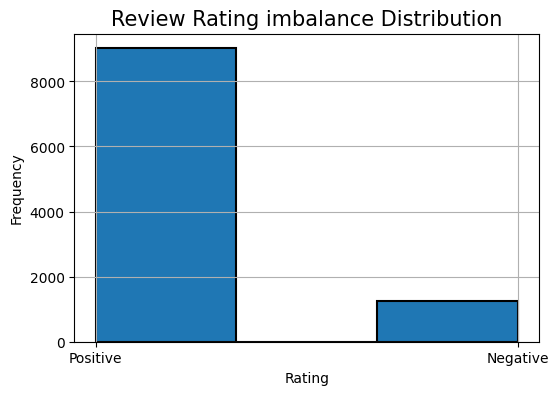

In [16]:
df['overall'].hist(
    bins=3,
    grid=True,
    figsize=(6, 4),
    edgecolor='black',
    linewidth=1.5,
)

plt.title("Review Rating imbalance Distribution", fontsize=15)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [17]:
tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ', oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df["cln_text"])
X = tokenizer.texts_to_sequences(df["cln_text"])
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH, padding=PADDING, truncating=PADDING)

Y = pd.get_dummies(df['overall']).values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=df["overall"], test_size = 0.1, random_state = 43, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y.argmax(axis=1)), y = Y.argmax(axis=1))
class_weights = dict(zip(np.unique(Y.argmax(axis=1)), class_weights)) 
print("class_weights: ", class_weights)

vocab_size = len(tokenizer.word_index) + 1

(9228, 32) (9228, 2)
(1026, 32) (1026, 2)
class_weights:  {0: 4.138014527845036, 1: 0.5687188019966722}


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 32)            666464    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 32, 32)            0         
 alDropout1D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

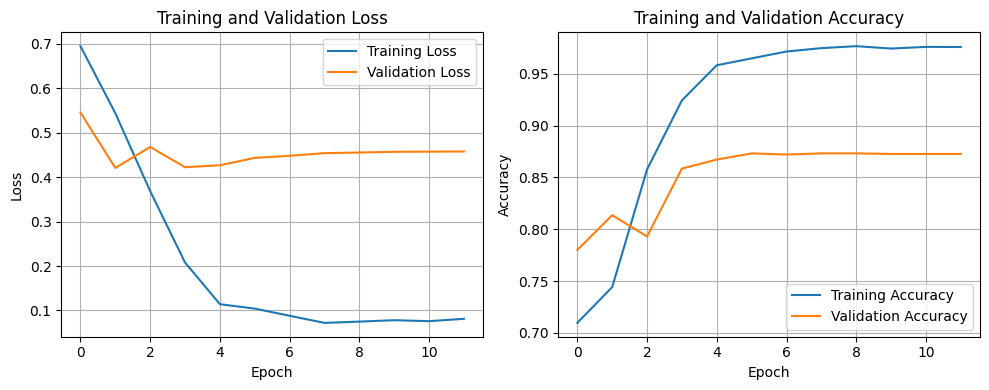

In [18]:
def build_model(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
    model.add(SpatialDropout1D(0.5))
    model.add(Flatten())
#     model.add(GlobalAveragePooling1D())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

batch_size = 16
model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)
history = model.fit(X_train, Y_train, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, y_pred.round()))
print('F1 score:', f1_score(Y_test, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round())) 

plot_history(history)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 32)            666464    
                                                                 
 spatial_dropout1d_4 (Spati  (None, 32, 32)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 32, 64)            16640     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 512)               16896     
                                                      

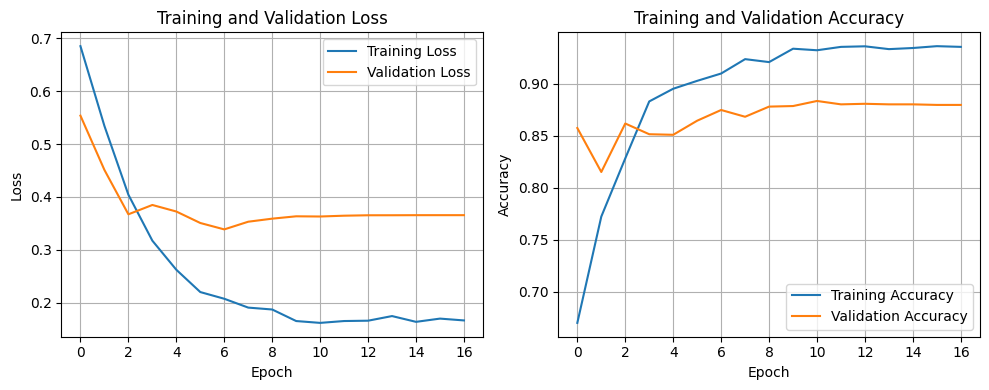

In [20]:
# Bi-LSTM model

def build_model(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
    model.add(SpatialDropout1D(0.5))
    model.add(Bidirectional(LSTM(32, recurrent_dropout=0.0, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(16, recurrent_dropout=0.0, dropout=0.5)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(Y_train.shape[1],activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

batch_size = 64
model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)
history = model.fit(X_train, Y_train, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, y_pred.round()))
print('F1 score:', f1_score(Y_test, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round()))

plot_history(history)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 32, 32)            666464    
                                                                 
 spatial_dropout1d_12 (Spat  (None, 32, 32)            0         
 ialDropout1D)                                                   
                                                                 
 conv1d_7 (Conv1D)           (None, 28, 128)           20608     
                                                                 
 bidirectional_13 (Bidirect  (None, 28, 128)           98816     
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                     

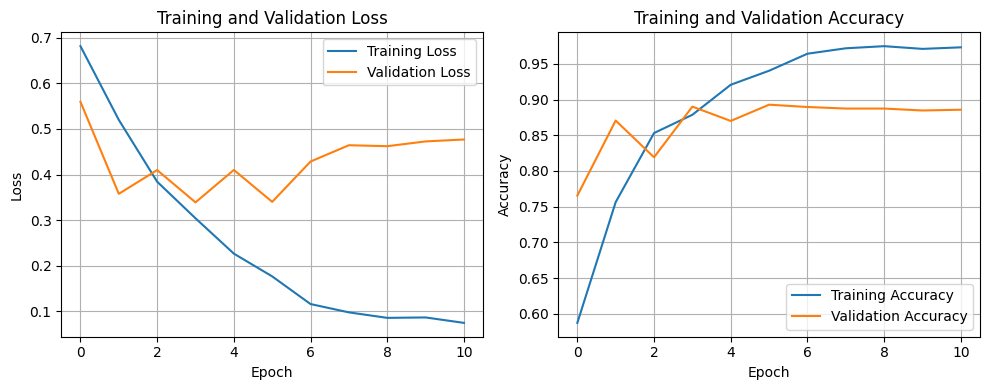

Model saved.


c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
def build_model(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, # Size of the vocabulary
                        output_dim=32, # Length of the vector for each word
                        input_length=max_seq_len)) # Maximum length of a sequence
    model.add(SpatialDropout1D(0.5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    # model.add(GlobalMaxPooling1D())
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.0, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, recurrent_dropout=0.0)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(Y_train.shape[1],activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=AdamW(learning_rate=0.001), 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

batch_size = 32
model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)

print("class_weights: ", class_weights)
history = model.fit(X_train, Y_train, 
                    class_weight=class_weights, # fix class imbalance
                    epochs = 25, batch_size=batch_size, validation_split=0.2,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 7, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                    ]
                   )

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, y_pred.round()))
print('F1 score:', f1_score(Y_test, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round())) 

plot_history(history)

model.save('model1.h5')
print("Model saved.")

Model with GloVe

In [33]:
NUM_WORDS = 30_000
MAX_SEQUENCE_LENGTH = 32
OOV_TOKEN = '<OOV>'
PADDING = 'post'

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ', oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df["cln_text"])
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(df["cln_text"])
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH, padding=PADDING, truncating=PADDING)
Y = pd.get_dummies(df['overall']).values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=df["overall"], test_size = 0.1, random_state = 43, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

vocab_size = len(tokenizer.word_index) + 1

GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
embeddings_index = {}
with open(GLOVE_EMB, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

EMBEDDING_MATRIX = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[i] = embedding_vector
        

(9228, 32) (9228, 2)
(1026, 32) (1026, 2)
Found 400001 word vectors.


Epoch 1/20
145/145 [==============================] - 14s 45ms/step - loss: 0.6442 - accuracy: 0.6270 - val_loss: 0.3984 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 2/20
145/145 [==============================] - 6s 41ms/step - loss: 0.5455 - accuracy: 0.7262 - val_loss: 0.3566 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 3/20
145/145 [==============================] - 6s 41ms/step - loss: 0.4866 - accuracy: 0.7581 - val_loss: 0.4405 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 4/20
145/145 [==============================] - 6s 41ms/step - loss: 0.4384 - accuracy: 0.7923 - val_loss: 0.3338 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 5/20
145/145 [==============================] - 6s 40ms/step - loss: 0.4031 - accuracy: 0.8107 - val_loss: 0.3552 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 6/20
145/145 [==============================] - 6s 41ms/step - loss: 0.3548 - accuracy: 0.8435 - val_loss: 0.2803 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 7/20
145/145 [==============================] - 6s 41ms/s

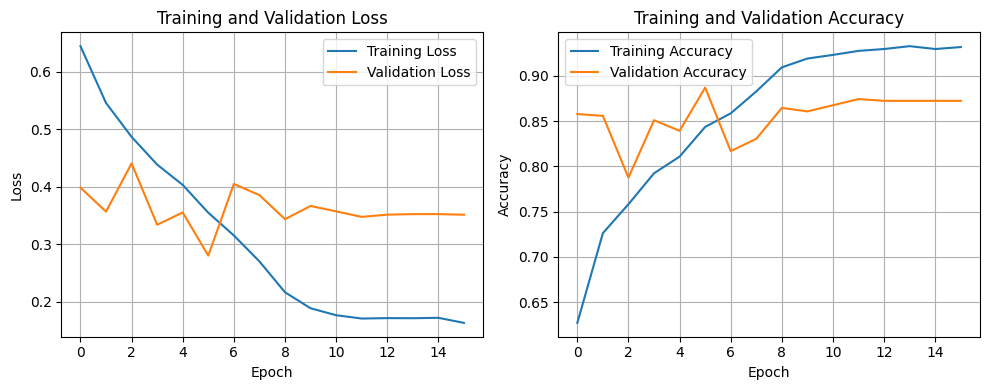

Model saved


c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau

embedding_layer = keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[EMBEDDING_MATRIX],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

sequence_input = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = keras.layers.SpatialDropout1D(0.2)(embedding_sequences)
x = keras.layers.Conv1D(64, 5, activation='relu')(x)
x = keras.layers.Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5))(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(Y_train.shape[1], activation='softmax')(x)
model = keras.Model(sequence_input, outputs)

LR = 0.001
BATCH_SIZE = 64
EPOCHS = 20

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y.argmax(axis=1)), y = Y.argmax(axis=1))
class_weights = dict(zip(np.unique(Y.argmax(axis=1)), class_weights)) 

model.compile(optimizer=keras.optimizers.AdamW(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    class_weight=class_weights, # fix class imbalance
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=(X_test, Y_test), 
                    callbacks=[ReduceLROnPlateau(factor=0.2,monitor = 'val_loss',patience=2,verbose = 1), 
                               EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)
                              ]
                   )

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, y_pred.round()))
print('F1 score:', f1_score(Y_test, y_pred.round(), average='weighted'))
print('ROC-AUC:', roc_auc_score(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round())) 

plot_history(history)

model.save('model_glove.h5')
print('Model saved')

LSTM + LSTM_GLOVE加权平均

In [41]:
from keras.models import load_model

model1 = load_model('model1.h5')
model_glove = load_model('model_glove.h5')

# 预测测试集
preds1 = model1.predict(X_test)
preds2 = model_glove.predict(X_test)

# 简单平均法
mean_preds = (preds1 + preds2) / 2

# 加权平均法，假设model1比model2更准确
weights = [0.6, 0.4]
weighted_preds = preds1 * weights[0] + preds2 * weights[1]

# 选择使用哪种集成策略的预测结果进行评估
final_preds = np.argmax(weighted_preds, axis=1)

# 计算准确度
accuracy = accuracy_score(Y_test.argmax(axis=1), final_preds)
print('集成模型的准确度:', accuracy)


33/33 [==============================] - 1s 7ms/step
集成模型的准确度: 0.9074074074074074


In [45]:
from sklearn.linear_model import LogisticRegression

preds_train_1 = model1.predict(X_train)
preds_test_1 = model1.predict(X_test)
preds_train_2 = model_glove.predict(X_train)
preds_test_2 = model_glove.predict(X_test)

X_train_meta = np.concatenate((preds_train_1, preds_train_2), axis=1)
X_test_meta = np.concatenate((preds_test_1, preds_test_2), axis=1)

Y_train_indices = np.argmax(Y_train, axis=1)

model_meta = LogisticRegression()
model_meta.fit(X_train_meta, Y_train_indices)

predictions = model_meta.predict(X_test_meta)
accuracy = accuracy_score(np.argmax(Y_test, axis=1), predictions)

print("Accuracy:", accuracy)
print(classification_report(np.argmax(Y_test, axis=1), predictions))

33/33 [==============================] - 0s 6ms/step
Accuracy: 0.9122807017543859
              precision    recall  f1-score   support

           0       0.71      0.47      0.56       124
           1       0.93      0.97      0.95       902

    accuracy                           0.91      1026
   macro avg       0.82      0.72      0.76      1026
weighted avg       0.90      0.91      0.90      1026



In [47]:
preds_train_1 = model1.predict(X_train)
preds_test_1 = model1.predict(X_test)
preds_train_2 = model_glove.predict(X_train)
preds_test_2 = model_glove.predict(X_test)

X_train_meta = np.concatenate((preds_train_1, preds_train_2), axis=1)
X_test_meta = np.concatenate((preds_test_1, preds_test_2), axis=1)

Y_train_indices = np.argmax(Y_train, axis=1)

model_meta = LogisticRegression()
model_meta.fit(X_train_meta, Y_train_indices)

predictions = model_meta.predict(X_test_meta)
accuracy = accuracy_score(np.argmax(Y_test, axis=1), predictions)

print("Accuracy:", accuracy)
print(classification_report(np.argmax(Y_test, axis=1), predictions))

33/33 [==============================] - 0s 7ms/step
Accuracy: 0.9122807017543859
              precision    recall  f1-score   support

           0       0.71      0.47      0.56       124
           1       0.93      0.97      0.95       902

    accuracy                           0.91      1026
   macro avg       0.82      0.72      0.76      1026
weighted avg       0.90      0.91      0.90      1026

